In [7]:
import os
import pandas as pd 
from sentence_transformers import SentenceTransformer
import scipy.spatial.distance
import scipy
import nltk
from nltk.corpus import stopwords
from utils.functions import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from yellowbrick.text import TSNEVisualizer
import numpy as np
import swifter
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [4]:
## Import annotated data
annotations = pd.read_csv('~/Documents/GitHub/CrisisBureaucracy/data/classifier/annotated-arguments-bureaucracy.csv')
annotations = annotations[["id","label","text"]]
annotations['metadata'] = ''

refdata = pd.read_csv('~/Documents/GitHub/CrisisBureaucracy/data/classifier/training_data_full.csv',sep='\t')
refdata['id-ann'] = [x + 594 for x in refdata.index]

for c,i in enumerate(annotations['id']):
    annotations['metadata'][c] = str(refdata[refdata['id-ann'] == i].reset_index(drop=True)['id'][0])


stops = stopwords.words('english') + ["hon","member","right","friend","mr",'hon.','make','say','great']
annotations['text'] = utils.preprocess_(annotations['text'])
annotations = annotations.drop('id',axis=1).reset_index(drop=True)

labels = {1:"neutral",2:"inefficient",3:"powerful/large",4:"centralization",5:"freedom",6:"expensive",7:"anti-democratic"}
annotations['label'] = annotations['label'].astype(str)

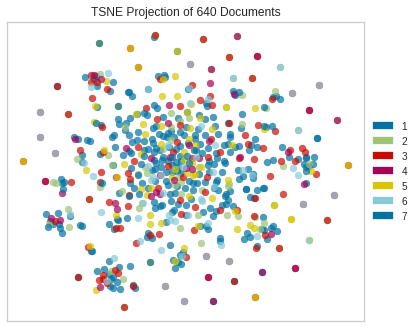

<AxesSubplot:title={'center':'TSNE Projection of 640 Documents'}>

In [9]:
# Embeddings with TFIDF
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(annotations['text'])
X_tfidf = tfidf_vect_ngram.transform(annotations['text'])
Y_tfidf = annotations.label

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X_tfidf, Y_tfidf)
tsne.show()

<AxesSubplot:xlabel='p0', ylabel='p1'>

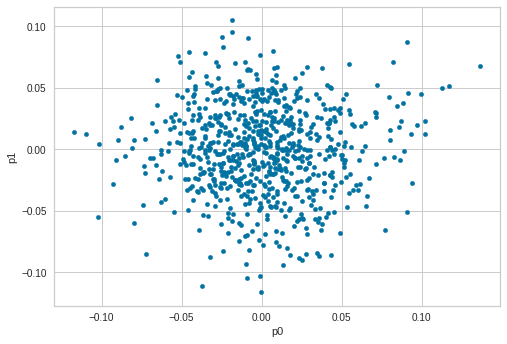

In [20]:
# Embeddings with SentenceBert
model = SentenceTransformer('bert-base-nli-mean-tokens')
vectors_swifter = annotations['text'].swifter.apply(model.encode)
annotations['sentence-bert'] = vectors_swifter
embdf = pd.DataFrame(list(vectors_swifter))

# Visualise after PCA dim. red. 
pca = PCA(n_components=2)
pca.fit(embdf)
pcadf = pd.DataFrame(pca.components_).T
pcadf.columns = ["p" + str(x) for x in pcadf.columns]
pcadf.plot.scatter(x='p0',y='p1')

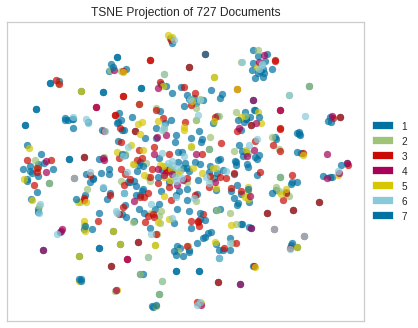

<AxesSubplot:title={'center':'TSNE Projection of 727 Documents'}>

In [14]:
# Create smaller windows around bureaucracy in annotations 
wda = utils.windowizer(annotations,words=['bureaucracy'],window=6,id_column="label")
wda['id'] = [x.split('-')[0] for x in wda['id']]
wda.columns = ['label','text']
annotations_wd = wda

# Embeddings with TFIDF
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(annotations_wd['text'])
X_tfidf = tfidf_vect_ngram.transform(annotations_wd['text'])
Y_tfidf = annotations.label

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X_tfidf, Y_tfidf)
tsne.show()

Pandas Apply: 100%|██████████| 727/727 [00:47<00:00, 15.24it/s]


<AxesSubplot:xlabel='p0', ylabel='p1'>

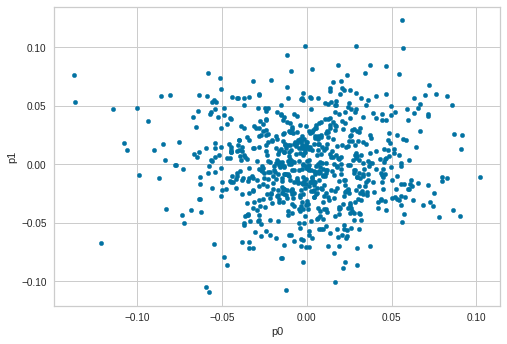

In [18]:
# Embeddings with SentenceBert
model = SentenceTransformer('bert-base-nli-mean-tokens')
vectors_swifter = annotations_wd['text'].swifter.apply(model.encode)
annotations_wd['sentence-bert'] = vectors_swifter
embdf = pd.DataFrame(list(vectors_swifter))

# Visualise after PCA dim. red. 
pca = PCA(n_components=2)
pca.fit(embdf)
pcadf = pd.DataFrame(pca.components_).T
pcadf.columns = ["p" + str(x) for x in pcadf.columns]
pcadf['label'] = annotations['label']
pcadf.plot.scatter(x='p0',y='p1')